In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import pickle

In [2]:
data_dir = '/opt/ml/input/data/train'

In [3]:
data_dir
df = pd.read_csv(os.path.join(data_dir,'train.csv'))
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


In [4]:
len(df)

2700

In [5]:
dir_list = []
for i in range(len(df)):
    dir_list.append(df['path'][i])

In [6]:
images_dir = data_dir + '/images/'
file_list = []
for dir_name in dir_list:
    #print(os.listdir(os.path.join(images_dir,dir_name)))
    #print(os.listdir(os.path.join(images_dir,dir_name)))
    temp = []
    for f in os.listdir(os.path.join(images_dir,dir_name)):
        if not f.startswith('.'):
            temp.append(f)
    file_list.append(temp)

In [7]:

f_idx = 0
print(len(file_list))
print(len(dir_list))

images_path = []
for i in range(len(file_list)):
    for j in range(len(file_list[i])):
        images_path.append(os.path.join(dir_list[i],file_list[i][j]))

2700
2700


In [8]:
with open('images_path.pickle','wb') as f:
    pickle.dump(images_path,f)

In [9]:
sex = []
age = []
mask_state = []
tag = []
for image_path in images_path:
    file_info = re.sub('[^a-zA-Z0-9]',' ',image_path)
    #print(image_path)
    ##print(file_info)
    if 'female' in file_info:
        sex.append('female')
        idx = file_info.index('female')
    else:
        sex.append('male')
        idx = file_info.index('male')
    file_info = file_info[idx:].split()
    age.append(int(file_info[2]))
    mask_state.append(file_info[3])
    #print(file_info)
    tag.append(file_info[-1])

In [10]:
info_df = pd.DataFrame(data={'sex':sex,
                            'age':age,
                            'mask_state': mask_state,
                            'tag':tag})
info_df.head()

,sex,age,mask_state,tag
0,female,45,normal,jpg
1,female,45,mask4,jpg
2,female,45,mask2,jpg
3,female,45,mask5,jpg
4,female,45,mask1,jpg


In [11]:
info_df['sex'].unique()

array(['female', 'male'], dtype=object)

In [12]:
info_df['age'].unique()

array([45, 52, 54, 58, 59, 56, 57, 55, 50, 49, 53, 51, 40, 25, 48, 29, 35,
       37, 19, 42, 24, 23, 30, 18, 22, 26, 21, 27, 60, 20, 28, 44, 34, 39,
       43, 33, 41, 47, 46, 36, 38, 32, 31])

In [13]:
info_df['mask_state'].unique()

array(['normal', 'mask4', 'mask2', 'mask5', 'mask1', 'mask3', 'incorrect'],
      dtype=object)

In [14]:
info_df['tag'].unique()

array(['jpg', 'png', 'jpeg'], dtype=object)

In [15]:
info_df['mask_state'] = info_df['mask_state'].apply(lambda x: 'mask' if x.startswith('mask') else x)

In [16]:
male_df = info_df[info_df['sex'] == 'male']
female_df = info_df[info_df['sex'] == 'female']

([<matplotlib.patches.Wedge at 0x7f5c50fd18b0>,
 [Text(0.39257483889210154, 1.0275626481479563, 'male'),
  Text(-0.3925747426847421, -1.0275626849034607, 'female')],
 [Text(0.21413173030478264, 0.5604887171716125, '38.4%'),
  Text(-0.2141316778280411, -0.5604887372200694, '61.6%')])

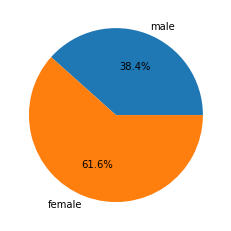

In [17]:
ratio = [len(male_df)*100//len(info_df), len(female_df)*100//len(info_df)]
labels = ['male', 'female']
#print(ratio)
plt.pie(ratio,labels=labels, autopct='%.1f%%')

In [25]:
under_30 = info_df[info_df['age'] < 30]
between_30_60 = info_df[(info_df['age'] >= 30) & (info_df['age'] < 60)]
over_60 = info_df[info_df['age'] >= 60]
bar_percent = [len(under_30)*100 / len(info_df),len(between_30_60)*100 / len(info_df),len(over_60)*100 / len(info_df)]

In [26]:
bar_percent # sns때 추가

[47.44444444444444, 45.44444444444444, 7.111111111111111]

<BarContainer object of 3 artists>

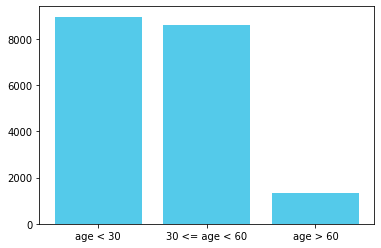

In [76]:
plt.bar(['age < 30', '30 <= age < 60', 'age > 60'],[len(under_30),len(between_30_60),len(over_60)],color = '#54CAEA')

In [77]:
mask = ['mask','incorrect','normal']
gender = ['male','female']

df_class = []
for m in mask:
    for g in gender:
        df_class.append(info_df[(info_df['mask_state'] == m) & (info_df['sex'] == g) & (info_df['age'] < 30)])
        df_class.append(info_df[(info_df['mask_state'] == m) & (info_df['sex'] == g) & (info_df['age'] > 30) & (info_df['age'] <= 60)])
        df_class.append(info_df[(info_df['mask_state'] == m) & (info_df['sex'] == g) & (info_df['age'] >= 60)])

In [78]:
len(df_class)

18

Text(0, 0.5, 'number of data')

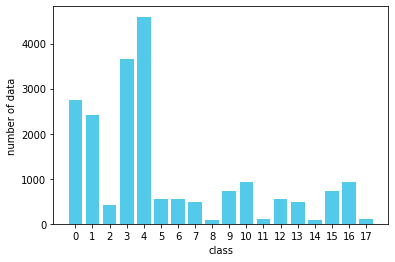

In [79]:
%matplotlib inline
df_class_cnt = list(map(len,df_class))
df_class_name = [str(s) for s in range(len(df_class))]
plt.bar(df_class_name,df_class_cnt,color = '#54CAEA')
plt.xlabel('class')
plt.ylabel('number of data')

In [80]:
info_df.head(10)

,sex,age,mask_state,tag
0,female,45,normal,jpg
1,female,45,mask,jpg
2,female,45,mask,jpg
3,female,45,mask,jpg
4,female,45,mask,jpg
5,female,45,mask,jpg
6,female,45,incorrect,jpg
7,female,52,normal,jpg
8,female,52,mask,jpg
9,female,52,mask,jpg


In [81]:
def convert_age(age):
    if age < 30:
        return 0
    elif 30 <= age < 60:
        return 1
    else:
        return 2


info_df['age'] = info_df['age'].apply(convert_age)

In [84]:
def convert_mask_state(mask):
    if mask == 'mask':
        return 0
    elif mask == 'incorrect':
        return 1
    else:
        return 2

info_df['mask_state'] = info_df['mask_state'].apply(convert_mask_state)

In [88]:
info_df['age'].unique()

array([1, 0, 2])

In [86]:
info_df.head(30)

,sex,age,mask_state,tag
0,female,1,2,jpg
1,female,1,0,jpg
2,female,1,0,jpg
3,female,1,0,jpg
4,female,1,0,jpg
5,female,1,0,jpg
6,female,1,1,jpg
7,female,1,2,jpg
8,female,1,0,jpg
9,female,1,0,jpg


In [87]:
info_df.to_csv('image_info.csv',index=False)